# Hyperparameters Tunning for Deep Learning Models (full of errors)
TODO add description

In [1]:
import optuna 
import sys; sys.path.append('..')
from thesis_package import utils, aimodels as myai, metrics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
num_trials = 30

c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Regression
y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns=['timestamps'])
exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
train_x, valid_x, train_y, valid_y, scaler_max = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
data_max_reg = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler_min = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
data_min_reg = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
# Threshold
threshold_max = utils.compute_threshold(y_max_u) /scaler_max['y']
threshold_min = utils.compute_threshold(y_min_u) /scaler_min['y']
print(threshold_min)
print(threshold_max)
# Classification
y_max_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u_sparse_bool[utils.cols_with_positive_values(y_max_u_sparse_bool)], test_size=0.2, scaling=True)
data_max_class = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}

y_min_u_sparse_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_sparse_bool_constr.csv').drop(columns=['timestamps'])
train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u_sparse_bool[utils.cols_with_positive_values(y_min_u_sparse_bool)], test_size=0.2, scaling=True)
data_min_class = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}

0.06450243730741544
0.054008631153497785


# Max u

## MLP: Sparse Classification Dataset

Build optuna study...

[I 2022-10-11 18:54:55,535] A new study created in memory with name: no-name-4b5b667c-8fac-46b0-802f-5a4731aebd0c
[I 2022-10-11 18:55:03,780] Trial 0 finished with value: 0.10123813614517593 and parameters: {'hidden_size': 46, 'n_layers': 1, 'dropout': 0.21956216823237673, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 6.53446893175287e-05, 'epochs': 2, 'batch_size': 256}. Best is trial 0 with value: 0.10123813614517593.
[I 2022-10-11 19:06:03,679] Trial 1 finished with value: 0.16688661108930072 and parameters: {'hidden_size': 54, 'n_layers': 3, 'dropout': 0.29723486655715725, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 9.275766595865167e-05, 'epochs': 96, 'batch_size': 2}. Best is trial 1 with value: 0.16688661108930072.
[I 2022-10-11 19:06:18,199] Trial 2 finished with value: 0.12925573263333254 and parameters: {'hidden_size': 11, 'n_layers': 1, 'dropout': 0.1629851628136027, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.006360360661893239, 'epochs': 6, 'batch_size': 

Number of finished trials:  30
Best trial:
  Value: 0.1944307654928048
  Params: 
    hidden_size: 96
    n_layers: 2
    dropout: 0.013655349449629942
    activation: tanh
    optimizer: adam
    lr: 0.00019771529138577486
    epochs: 35
    batch_size: 64


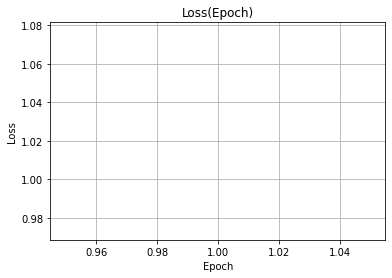

In [3]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_max_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns='timestamps') 
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    X_max_u_bool_train, X_max_u_bool_test, y_max_u_bool_train, y_max_u_bool_test, scaler = utils.split_and_suffle(exogenous_data, y_max_u_bool[utils.cols_with_positive_values(y_max_u_bool)], test_size=0.2, scaling=True)
    data = {'X_train':X_max_u_bool_train.astype(float),
            'X_test': X_max_u_bool_test.astype(float),
            'y_train':y_max_u_bool_train.astype(float),
            'y_test': y_max_u_bool_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': True
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_max_class)
    prediction = pd.DataFrame(prediction, columns=utils.cols_with_positive_values(y_max_u_bool))
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (data_max_class['y_test'][bus] == 1))
        tn += sum((prediction[bus] == 0) & (data_max_class['y_test'][bus] == 0))
        fp += sum((prediction[bus] == 1) & (data_max_class['y_test'][bus] == 0))
        fn += sum((prediction[bus] == 0) & (data_max_class['y_test'][bus] == 1))
    mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_sparse_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,True\n")
    f.write("value,{}\n".format(trial.value))

In [4]:
y_max_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_sparse_bool_constr.csv').drop(columns='timestamps') 

In [5]:
y_max_u_bool.columns

Index(['ext_grid', 'bus_1', 'bus_2', 'bus_3', 'bus_4', 'bus_5', 'bus_6',
       'bus_7', 'bus_8', 'bus_9', 'bus_10', 'bus_11', 'bus_12', 'bus_13',
       'bus_14', 'bus_15', 'bus_16', 'bus_19', 'bus_20', 'bus_22', 'bus_25',
       'bus_26', 'bus_28', 'bus_29', 'bus_30', 'bus_31', 'bus_17', 'bus_21',
       'bus_24', 'bus_18', 'bus_23', 'bus_27', 'bus_32', 'bus_33'],
      dtype='object')

Now we confirm that the target feature is created correctly, being in accord with the sparse dataset.

## MLP: Balanced Classification Dataset

[I 2022-10-11 20:18:32,958] A new study created in memory with name: no-name-e5ccfb5e-787d-4ce9-86c1-86aa93bc5657
[I 2022-10-11 20:19:15,766] Trial 0 finished with value: 0.10378099011626724 and parameters: {'hidden_size': 13, 'n_layers': 3, 'dropout': 0.4015876650362663, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.022124155737013387, 'epochs': 87, 'batch_size': 2}. Best is trial 0 with value: 0.10378099011626724.
[I 2022-10-11 20:19:20,685] Trial 1 finished with value: 0.019991963139548218 and parameters: {'hidden_size': 79, 'n_layers': 2, 'dropout': 0.3926001200944006, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 8.195338256501777e-05, 'epochs': 13, 'batch_size': 8}. Best is trial 0 with value: 0.10378099011626724.
[I 2022-10-11 20:19:21,788] Trial 2 finished with value: -0.01544614905492283 and parameters: {'hidden_size': 50, 'n_layers': 3, 'dropout': 0.4196942467937907, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 8.159888848063572e-05, 'epochs': 2, 'batch_size': 512}.

Number of finished trials:  30
Best trial:
  Value: 0.2076365916650618
  Params: 
    hidden_size: 88
    n_layers: 3
    dropout: 0.06624961197723803
    activation: tanh
    optimizer: adam
    lr: 0.00021523947986686875
    epochs: 97
    batch_size: 256


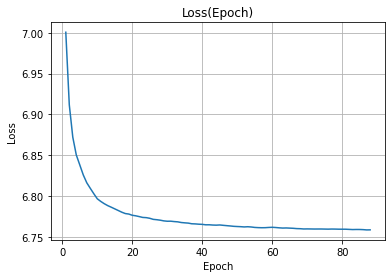

In [6]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_max_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_balanced_bool_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_balanced.csv').drop(columns=['date'])
    X_max_u_bool_train, X_max_u_bool_test, y_max_u_bool_train, y_max_u_bool_test, scaler = utils.split_and_suffle(exogenous_data, y_max_u_bool[utils.cols_with_positive_values(y_max_u_bool)], test_size=0.2, scaling=True)
    data = {'X_train':X_max_u_bool_train.astype(float),
            'X_test': X_max_u_bool_test.astype(float),
            'y_train':y_max_u_bool_train.astype(float),
            'y_test': y_max_u_bool_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': True
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_max_class)
    prediction = pd.DataFrame(prediction, columns=utils.cols_with_positive_values(y_max_u_bool))
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (data_max_class['y_test'][bus] == 1))
        tn += sum((prediction[bus] == 0) & (data_max_class['y_test'][bus] == 0))
        fp += sum((prediction[bus] == 1) & (data_max_class['y_test'][bus] == 0))
        fn += sum((prediction[bus] == 0) & (data_max_class['y_test'][bus] == 1))
    mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_balanced_classifier_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,True\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Regression Sparse Dataset

[I 2022-10-11 20:34:06,066] A new study created in memory with name: no-name-727b8965-0488-4e52-9583-b0c1fc7ab249
[I 2022-10-11 20:37:14,227] Trial 0 finished with value: 0.1331702461303271 and parameters: {'hidden_size': 16, 'n_layers': 3, 'dropout': 0.2537763582209544, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.006989677938342164, 'epochs': 51, 'batch_size': 1}. Best is trial 0 with value: 0.1331702461303271.
[I 2022-10-11 20:39:10,401] Trial 1 finished with value: 0.12842714923355375 and parameters: {'hidden_size': 95, 'n_layers': 3, 'dropout': 0.12316494341855255, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.0005823287769279183, 'epochs': 19, 'batch_size': 512}. Best is trial 0 with value: 0.1331702461303271.
[I 2022-10-11 20:41:38,215] Trial 2 finished with value: -0.5861798434094343 and parameters: {'hidden_size': 79, 'n_layers': 3, 'dropout': 0.10034935505284936, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.043595183253444365, 'epochs': 23, 'batch_size'

Number of finished trials:  30
Best trial:
  Value: 0.23908612324680312
  Params: 
    hidden_size: 31
    n_layers: 1
    dropout: 0.4863118778830751
    activation: sigmoid
    optimizer: adam
    lr: 9.098933848299788e-05
    epochs: 13
    batch_size: 32


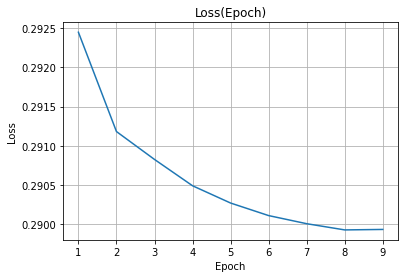

In [7]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns='timestamps')
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train':X_max_u_train.astype(float),
            'X_test': X_max_u_test.astype(float),
            'y_train':y_max_u_train.astype(float),
            'y_test': y_max_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_max_reg)
    prediction = pd.DataFrame(prediction, columns=y_max_u.columns)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_max_reg['y_test'], threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_sparse_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Regression Focused Dataset

[I 2022-10-12 10:39:27,343] A new study created in memory with name: no-name-b4217da8-6404-4384-a72c-6a7a21af2a19
[I 2022-10-12 10:40:41,606] Trial 0 finished with value: 0.024497474103154976 and parameters: {'hidden_size': 68, 'n_layers': 3, 'dropout': 0.3898452385193764, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 1.5406125384223418e-05, 'epochs': 82, 'batch_size': 8}. Best is trial 0 with value: 0.024497474103154976.
[I 2022-10-12 10:41:25,180] Trial 1 finished with value: 0.21878851381116945 and parameters: {'hidden_size': 11, 'n_layers': 3, 'dropout': 0.3519964637747069, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.006197644742236854, 'epochs': 1, 'batch_size': 2}. Best is trial 1 with value: 0.21878851381116945.
[I 2022-10-12 10:42:03,057] Trial 2 finished with value: 0.053560042611659794 and parameters: {'hidden_size': 56, 'n_layers': 2, 'dropout': 0.2840089467446075, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 5.402150742833307e-05, 'epochs': 1, 'batch_size': 4

Number of finished trials:  30
Best trial:
  Value: 0.23933420230066543
  Params: 
    hidden_size: 37
    n_layers: 3
    dropout: 0.23369787210186146
    activation: sigmoid
    optimizer: adam
    lr: 0.054342682853257544
    epochs: 24
    batch_size: 32


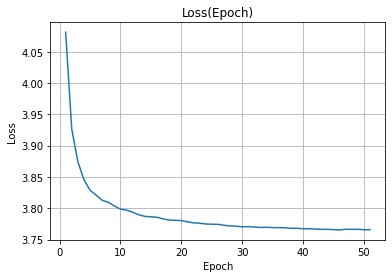

In [17]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_focused_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_focused.csv').drop(columns=['date'])
    X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test, scaler = utils.split_and_suffle(exogenous_data, y_max_u, scaling=True)
    data = {'X_train':X_max_u_train.astype(float),
            'X_test': X_max_u_test.astype(float),
            'y_train':y_max_u_train.astype(float),
            'y_test': y_max_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    # print(model.strategy.model.eval())
    prediction = model.predict(data_max_reg)
    prediction = pd.DataFrame(prediction, columns=y_max_u.columns)
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_max_reg['y_test'], threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_focused_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Regression Filtered Dataset

[I 2022-10-11 22:16:36,405] A new study created in memory with name: no-name-b0db9e35-acc7-4ff9-97a4-d22a5bf0a991
[I 2022-10-11 22:20:33,090] Trial 0 finished with value: 0.08350977870926284 and parameters: {'hidden_size': 41, 'n_layers': 2, 'dropout': 0.18737970739115906, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.00034457349475340126, 'epochs': 49, 'batch_size': 1024}. Best is trial 0 with value: 0.08350977870926284.
[I 2022-10-11 22:24:52,189] Trial 1 finished with value: 0.21788706324376234 and parameters: {'hidden_size': 85, 'n_layers': 3, 'dropout': 0.07745347417297999, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.038919695270299384, 'epochs': 29, 'batch_size': 2}. Best is trial 1 with value: 0.21788706324376234.
[I 2022-10-11 22:26:27,213] Trial 2 finished with value: 0.6057057289742825 and parameters: {'hidden_size': 30, 'n_layers': 1, 'dropout': 0.026142792607936505, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.000912435841009572, 'epochs': 30, 'batch_size

Number of finished trials:  30
Best trial:
  Value: 0.6057057289742825
  Params: 
    hidden_size: 30
    n_layers: 1
    dropout: 0.026142792607936505
    activation: sigmoid
    optimizer: sgd
    lr: 0.000912435841009572
    epochs: 30
    batch_size: 64


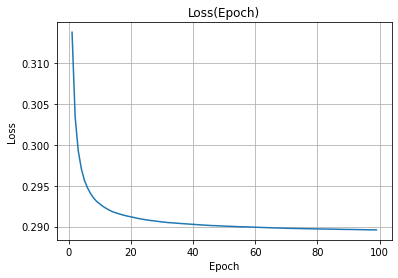

In [9]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_constr.csv').drop(columns='timestamps')
    y_max_u = y_max_u[utils.cols_with_positive_values(y_max_u)]
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train':X_max_u_train.astype(float),
            'X_test': X_max_u_test.astype(float),
            'y_train':y_max_u_train.astype(float),
            'y_test': y_max_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_max_reg)
    prediction = pd.DataFrame(prediction, columns=y_max_u.columns)
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_max_reg['y_test'][prediction.columns], threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_filtered_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

# Min u

## MLP: Sparse Classification Dataset

[I 2022-10-11 23:55:44,793] A new study created in memory with name: no-name-ca8b8744-42f4-4848-aa54-8850fbc5432c
[I 2022-10-11 23:55:54,123] Trial 0 finished with value: 0.17049753398494594 and parameters: {'hidden_size': 16, 'n_layers': 2, 'dropout': 0.06435535317685281, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.03939901468037142, 'epochs': 3, 'batch_size': 256}. Best is trial 0 with value: 0.17049753398494594.
[I 2022-10-12 00:06:12,839] Trial 1 finished with value: 0.19951311573318037 and parameters: {'hidden_size': 87, 'n_layers': 3, 'dropout': 0.13748487887420796, 'activation': 'relu', 'optimizer': 'adam', 'lr': 1.0498473255119416e-05, 'epochs': 98, 'batch_size': 64}. Best is trial 1 with value: 0.19951311573318037.
[I 2022-10-12 00:06:41,992] Trial 2 finished with value: 0.17819032099254267 and parameters: {'hidden_size': 61, 'n_layers': 2, 'dropout': 0.28325942382445835, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.0030025693732338445, 'epochs': 8, 'batch_size

Number of finished trials:  30
Best trial:
  Value: 0.277318282293507
  Params: 
    hidden_size: 67
    n_layers: 3
    dropout: 0.05278884826693009
    activation: relu
    optimizer: adam
    lr: 0.0004383841784714103
    epochs: 86
    batch_size: 512


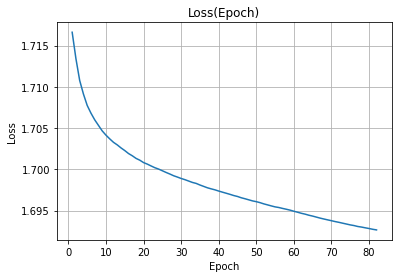

In [10]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_min_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_sparse_bool_constr.csv').drop(columns='timestamps')
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    X_min_u_bool_train, X_min_u_bool_test, y_min_u_bool_train, y_min_u_bool_test, scaler = utils.split_and_suffle(exogenous_data, y_min_u_bool[utils.cols_with_positive_values(y_min_u_bool)], test_size=0.2, scaling=True)
    data = {'X_train':X_min_u_bool_train.astype(float),
            'X_test': X_min_u_bool_test.astype(float),
            'y_train':y_min_u_bool_train.astype(float),
            'y_test': y_min_u_bool_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': True
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_min_class)       
    prediction = pd.DataFrame(prediction, columns=utils.cols_with_positive_values(y_min_u_bool))
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (data_min_class['y_test'][bus] == 1))
        tn += sum((prediction[bus] == 0) & (data_min_class['y_test'][bus] == 0))
        fp += sum((prediction[bus] == 1) & (data_min_class['y_test'][bus] == 0))
        fn += sum((prediction[bus] == 0) & (data_min_class['y_test'][bus] == 1))
    mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_sparse_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,True\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Balanced Classification Dataset

[I 2022-10-12 02:45:02,657] A new study created in memory with name: no-name-5e153e7c-9819-4d86-aad4-96523a394f64
[I 2022-10-12 02:45:56,363] Trial 0 finished with value: 0.2304077262017171 and parameters: {'hidden_size': 30, 'n_layers': 1, 'dropout': 0.4152657834564196, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.062032037432359084, 'epochs': 62, 'batch_size': 256}. Best is trial 0 with value: 0.2304077262017171.
[I 2022-10-12 02:48:19,871] Trial 1 finished with value: 0.2029832252293598 and parameters: {'hidden_size': 53, 'n_layers': 3, 'dropout': 0.05286335288910249, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 7.682456107663536e-05, 'epochs': 100, 'batch_size': 16}. Best is trial 0 with value: 0.2304077262017171.
[I 2022-10-12 02:48:43,520] Trial 2 finished with value: 0.15407385502185547 and parameters: {'hidden_size': 59, 'n_layers': 2, 'dropout': 0.2713086038895366, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.06700908429376028, 'epochs': 23, 'batch_size': 102

Number of finished trials:  30
Best trial:
  Value: 0.24376806644558535
  Params: 
    hidden_size: 93
    n_layers: 1
    dropout: 0.2567761330261016
    activation: sigmoid
    optimizer: adam
    lr: 0.007067153262594293
    epochs: 89
    batch_size: 16


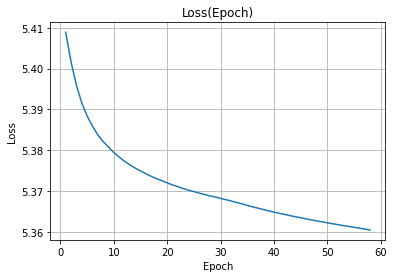

In [11]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_min_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_balanced_bool_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_balanced.csv').drop(columns=['date'])
    X_max_u_bool_train, X_max_u_bool_test, y_max_u_bool_train, y_max_u_bool_test, scaler = utils.split_and_suffle(exogenous_data, y_min_u_bool[utils.cols_with_positive_values(y_min_u_bool)], test_size=0.2, scaling=True)
    data = {'X_train':X_max_u_bool_train.astype(float),
            'X_test': X_max_u_bool_test.astype(float),
            'y_train':y_max_u_bool_train.astype(float),
            'y_test': y_max_u_bool_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': True
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_min_class)
    prediction = pd.DataFrame(prediction, columns=utils.cols_with_positive_values(y_min_u_bool))
    tp, tn, fp, fn = 0, 0, 0, 0
    for bus in prediction.columns:
        tp += sum((prediction[bus] == 1) & (data_min_class['y_test'][bus] == 1))
        tn += sum((prediction[bus] == 0) & (data_min_class['y_test'][bus] == 0))
        fp += sum((prediction[bus] == 1) & (data_min_class['y_test'][bus] == 0))
        fn += sum((prediction[bus] == 0) & (data_min_class['y_test'][bus] == 1))
    mcc_score = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return mcc_score
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_balanced_classifier_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,True\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Regression Sparse Dataset

[I 2022-10-12 03:14:53,397] A new study created in memory with name: no-name-70436556-6c3c-4b0c-b470-ba2073c4a3f5
[I 2022-10-12 03:16:57,278] Trial 0 finished with value: 0.305028785839454 and parameters: {'hidden_size': 88, 'n_layers': 1, 'dropout': 0.19921430309138527, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 1.0964389357017035e-05, 'epochs': 35, 'batch_size': 64}. Best is trial 0 with value: 0.305028785839454.
[I 2022-10-12 03:22:29,282] Trial 1 finished with value: 0.27364510195444774 and parameters: {'hidden_size': 48, 'n_layers': 2, 'dropout': 0.08414417561464144, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.0011332852662332667, 'epochs': 85, 'batch_size': 1024}. Best is trial 0 with value: 0.305028785839454.
[I 2022-10-12 03:24:07,752] Trial 2 finished with value: 0.046720398937252924 and parameters: {'hidden_size': 47, 'n_layers': 3, 'dropout': 0.22342858401774857, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.0019168079780038248, 'epochs': 16, 'batch_size'

Number of finished trials:  30
Best trial:
  Value: 0.305028785839454
  Params: 
    hidden_size: 88
    n_layers: 1
    dropout: 0.19921430309138527
    activation: tanh
    optimizer: adam
    lr: 1.0964389357017035e-05
    epochs: 35
    batch_size: 64


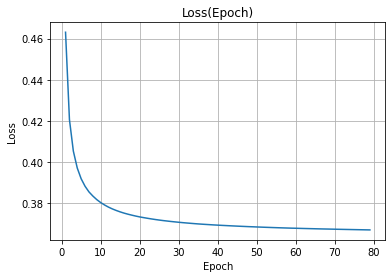

In [12]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns='timestamps')
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    X_min_u_train, X_min_u_test, y_min_u_train, y_min_u_test, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train':X_min_u_train.astype(float),
            'X_test': X_min_u_test.astype(float),
            'y_train':y_min_u_train.astype(float),
            'y_test': y_min_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_min_class)
    prediction = pd.DataFrame(prediction, columns=y_min_u.columns)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_min_reg['y_test'], threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_sparse_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Regression Focused Dataset

[I 2022-10-12 11:00:51,316] A new study created in memory with name: no-name-2ea55109-d1fd-4446-b05c-5c26d195a610
[I 2022-10-12 11:01:37,862] Trial 0 finished with value: 0.194375176238762 and parameters: {'hidden_size': 7, 'n_layers': 2, 'dropout': 0.28640836471088615, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.051059424836098787, 'epochs': 41, 'batch_size': 512}. Best is trial 0 with value: 0.194375176238762.
[I 2022-10-12 11:02:16,943] Trial 1 finished with value: 0.24666375370025495 and parameters: {'hidden_size': 83, 'n_layers': 1, 'dropout': 0.4049284813963393, 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.008042190945511498, 'epochs': 17, 'batch_size': 4}. Best is trial 1 with value: 0.24666375370025495.
[I 2022-10-12 11:02:53,973] Trial 2 finished with value: 0.2590390916871134 and parameters: {'hidden_size': 91, 'n_layers': 2, 'dropout': 0.0011454447507394105, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 1.861295920522715e-05, 'epochs': 11, 'batch_size': 1}

Number of finished trials:  30
Best trial:
  Value: 0.3089448108180535
  Params: 
    hidden_size: 80
    n_layers: 2
    dropout: 0.457350255024655
    activation: tanh
    optimizer: adam
    lr: 0.012743491505149463
    epochs: 89
    batch_size: 128


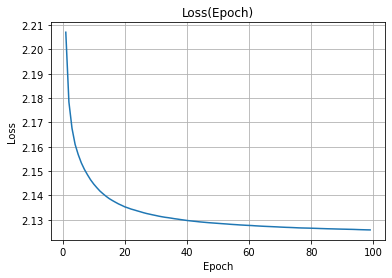

In [18]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_focused_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_focused.csv').drop(columns=['date'])
    X_min_u_train, X_min_u_test, y_min_u_train, y_min_u_test, scaler = utils.split_and_suffle(exogenous_data, y_min_u, scaling=True)
    data = {'X_train':X_min_u_train.astype(float),
            'X_test': X_min_u_test.astype(float),
            'y_train':y_min_u_train.astype(float),
            'y_test': y_min_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    # print(model.strategy.model.eval())
    prediction = model.predict(data_min_reg)
    prediction = pd.DataFrame(prediction, columns=y_min_u.columns)
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_min_reg['y_test'], threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_focused_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

## Regression Filtered Dataset

[I 2022-10-12 05:07:35,421] A new study created in memory with name: no-name-e6b7de2c-bc51-4c17-b57f-fbaf2e747e4c
[I 2022-10-12 05:08:00,806] Trial 0 finished with value: 0.2282209159012125 and parameters: {'hidden_size': 95, 'n_layers': 3, 'dropout': 0.07969144399606698, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.034052357158140596, 'epochs': 3, 'batch_size': 8}. Best is trial 0 with value: 0.2282209159012125.
[I 2022-10-12 05:09:55,106] Trial 1 finished with value: 0.12659597968788616 and parameters: {'hidden_size': 85, 'n_layers': 1, 'dropout': 0.3958069874842727, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 9.827293531091858e-05, 'epochs': 56, 'batch_size': 4}. Best is trial 0 with value: 0.2282209159012125.
[I 2022-10-12 05:14:02,881] Trial 2 finished with value: 0.2013896631062636 and parameters: {'hidden_size': 91, 'n_layers': 2, 'dropout': 0.36545214123275704, 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.00011090436768622155, 'epochs': 72, 'batch_size': 64}.

Number of finished trials:  30
Best trial:
  Value: 0.6912324689925611
  Params: 
    hidden_size: 30
    n_layers: 1
    dropout: 0.28012208837939606
    activation: sigmoid
    optimizer: sgd
    lr: 0.0009630990229242362
    epochs: 88
    batch_size: 256


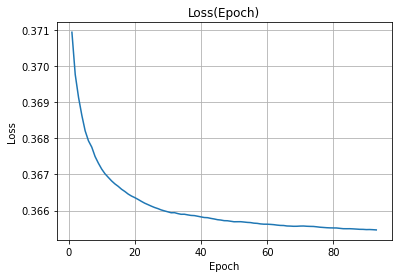

In [14]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_constr.csv').drop(columns='timestamps')
    exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
    X_min_u_train, X_min_u_test, y_min_u_train, y_min_u_test, scaler = utils.split_and_suffle(exogenous_data, y_min_u[utils.cols_with_positive_values(y_min_u)], test_size=0.2, scaling=True)
    data = {'X_train':X_min_u_train.astype(float),
            'X_test': X_min_u_test.astype(float),
            'y_train':y_min_u_train.astype(float),
            'y_test': y_min_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_min_reg)
    prediction = pd.DataFrame(prediction, columns=utils.cols_with_positive_values(y_min_u))
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_min_reg['y_test'][prediction.columns], threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_filtered_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

## MLP: Regression Balanced Dataset

[I 2022-10-12 06:24:47,421] A new study created in memory with name: no-name-69f266ab-64ab-44a9-a491-b519a86fa983
[I 2022-10-12 06:25:50,382] Trial 0 finished with value: 0.08488734232243897 and parameters: {'hidden_size': 5, 'n_layers': 1, 'dropout': 0.18998865444671503, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 5.613455343247345e-05, 'epochs': 28, 'batch_size': 32}. Best is trial 0 with value: 0.08488734232243897.
[I 2022-10-12 06:28:50,017] Trial 1 finished with value: 0.17640304667237397 and parameters: {'hidden_size': 97, 'n_layers': 2, 'dropout': 0.22132519368499187, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 1.9995635958997307e-05, 'epochs': 70, 'batch_size': 2}. Best is trial 1 with value: 0.17640304667237397.
[I 2022-10-12 06:30:45,472] Trial 2 finished with value: 0.26803606431832033 and parameters: {'hidden_size': 63, 'n_layers': 2, 'dropout': 0.34466168811848585, 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.0007252882110512738, 'epochs': 23, 'batch

Number of finished trials:  30
Best trial:
  Value: 0.34618337833031865
  Params: 
    hidden_size: 15
    n_layers: 1
    dropout: 0.15780196616971087
    activation: relu
    optimizer: adam
    lr: 3.0734592698099293e-05
    epochs: 13
    batch_size: 1


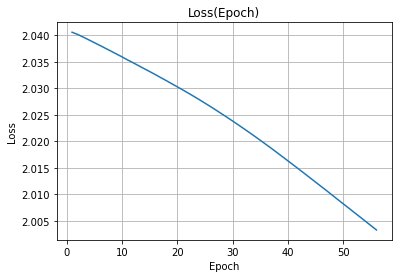

In [15]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_balanced_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_balanced.csv').drop(columns=['date'])
    X_min_u_train, X_min_u_test, y_min_u_train, y_min_u_test, scaler = utils.split_and_suffle(exogenous_data, y_min_u, test_size=0.2, scaling=True)
    data = {'X_train':X_min_u_train.astype(float),
            'X_test': X_min_u_test.astype(float),
            'y_train':y_min_u_train.astype(float),
            'y_test': y_min_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_min_reg)
    prediction = pd.DataFrame(prediction, columns=y_min_u.columns)
    y_min_u_train = pd.DataFrame(y_min_u_train, columns=y_min_u.columns)
    # evaluate the regression performance with my metrics
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_min_reg['y_test'], threshold=threshold_min)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_balanced_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))

[I 2022-10-12 07:00:12,603] A new study created in memory with name: no-name-c3e726c9-7c6a-4043-ac1c-c843c48897f7
[I 2022-10-12 07:00:56,846] Trial 0 finished with value: 0.0 and parameters: {'hidden_size': 11, 'n_layers': 2, 'dropout': 0.16359356987346652, 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.0004853237480739025, 'epochs': 65, 'batch_size': 128}. Best is trial 0 with value: 0.0.
[I 2022-10-12 07:01:37,048] Trial 1 finished with value: 0.02899303294601774 and parameters: {'hidden_size': 4, 'n_layers': 1, 'dropout': 0.12274470250858904, 'activation': 'tanh', 'optimizer': 'sgd', 'lr': 1.0441909940303813e-05, 'epochs': 60, 'batch_size': 1024}. Best is trial 1 with value: 0.02899303294601774.
[I 2022-10-12 07:02:25,933] Trial 2 finished with value: 0.08206905657153682 and parameters: {'hidden_size': 98, 'n_layers': 1, 'dropout': 0.42882076686829707, 'activation': 'sigmoid', 'optimizer': 'sgd', 'lr': 0.000505850010443583, 'epochs': 77, 'batch_size': 1024}. Best is trial 2 with 

Number of finished trials:  30
Best trial:
  Value: 0.2585468824463755
  Params: 
    hidden_size: 56
    n_layers: 1
    dropout: 0.07023952502546275
    activation: tanh
    optimizer: adam
    lr: 1.079686772327594e-05
    epochs: 19
    batch_size: 8


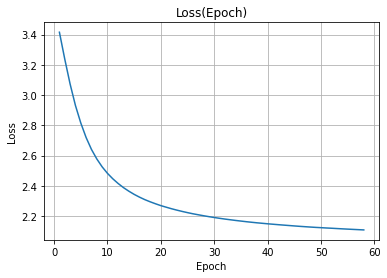

In [16]:
# Build optuna objective function.
import optuna
import sklearn 

def objective(trial):
    # Data loading
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_balanced_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_balanced.csv').drop(columns=['date'])
    X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test, scaler = utils.split_and_suffle(exogenous_data, y_max_u, test_size=0.2, scaling=True)
    data = {'X_train':X_max_u_train.astype(float),
            'X_test': X_max_u_test.astype(float),
            'y_train':y_max_u_train.astype(float),
            'y_test': y_max_u_test.astype(float)
        }
    # Dataset object creation
    _dataset = myai.ThesisDataset(data)
    hyper_params = {
        'input_size': _dataset.X.shape[1],
        'hidden_size': trial.suggest_int('hidden_size', 1, 100),
        'output_size': _dataset.y.shape[1],
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid']),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'sgd']),
        'lr': trial.suggest_float('lr', 1e-5, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 1, 100),
        'batch_size': trial.suggest_categorical('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]),
        'classifier': False
        }
    model = myai.Context(myai.MultilayerPerceptronStrategy(hyper_params))
    model.fit(data)
    prediction = model.predict(data_max_reg)
    prediction = pd.DataFrame(prediction, columns=y_max_u.columns)
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, data_max_reg['y_test'], threshold=threshold_max)
    return metric.hybrid_mcc
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results_mcc/params_mlp_regression_balanced_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("classifier,False\n")
    f.write("value,{}\n".format(trial.value))